# EGNO supergravity

In [1]:
import sympy
import numpy as np
from einsteinpy.symbolic import MetricTensor, RicciScalar

#import inflatox
from inflatox import (SymbolicCalculation, Compiler, consistency_conditions)
sympy.init_printing()

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

#A4 tufte layout paper figure sizes
MARGIN_FIG = lambda scale: (1.99, 1.99*scale)
MAIN_FIG = lambda scale: (4.18, 4.18*scale)
FULL_FIG = lambda scale: (6.64, 6.64*scale)

#Fontsize configuration
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', family='JetBrains Mono')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#Other matplotlib configuration
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.autolayout'] = True
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Fira Code'
plt.rcParams['mathtext.it'] = 'Fira Code'
plt.ioff()

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


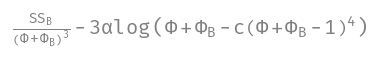

In [3]:
alpha, m, p, c, a = sympy.symbols('alpha m p c a')
r, θ = sympy.symbols('r θ')
fields = [r, θ]

Phi, Phi_Bar, S, S_Bar = sympy.symbols('Phi Phi_B S S_B')

K = (-3*alpha*sympy.ln(
  Phi + Phi_Bar - c*((Phi + Phi_Bar - 1))**4
) + (S*S_Bar)/(Phi + Phi_Bar)**3).nsimplify()
display(K)

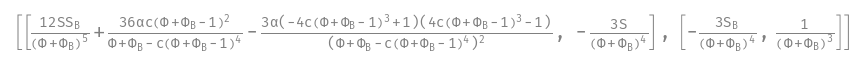

In [4]:
superfields = [Phi, S]
superfields_conjugate = [Phi_Bar, S_Bar]
metric = [[sympy.diff(sympy.diff(K, superfields[b]), superfields_conjugate[a]) for a in range(0,2)] for b in range(0,2)]
display(metric)

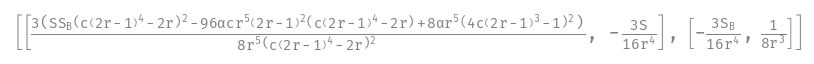

In [5]:
metric = [[g.subs({Phi: r+1j*θ, Phi_Bar:r-1j*θ}).nsimplify().simplify() for g in gb] for gb in metric]
display(metric)

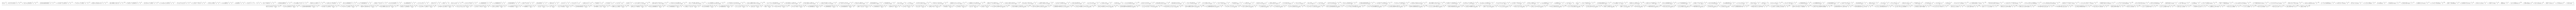

In [6]:
metric_tensor = MetricTensor(metric, fields)
R = RicciScalar.from_metric(metric_tensor).expr
display(R)

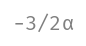

In [8]:
sympy.limit(R, r, float('inf'))

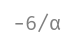

In [10]:
sympy.limit(R, c, 0).subs({S: 0, S_Bar: 0})

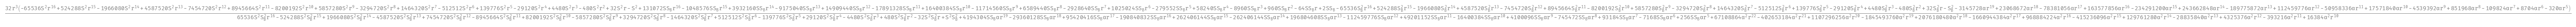

In [11]:
sympy.limit(R.collect([alpha,c]), c, float('inf'))

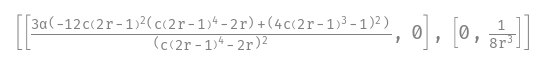

In [6]:
metric = [[g.subs({S: 0, S_Bar: 0}).simplify() for g in gb] for gb in metric]
display(metric)

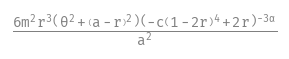

In [7]:
potential = (
  (6*m**2*r**3*((a-r)**2+θ**2)) / (a**2*(2*r-c*(1-2*r)**4)**(3*alpha))
).nsimplify()
display(potential)

In [8]:
hesse = SymbolicCalculation.new_from_list(
  fields,
  metric,
  potential,
  simplify_for='length',
  simplification_depth=1,
  silent=True
).execute([[0,1]])

Calculating covariant Hesse matrix...
Projecting the Hesse matrix on the vielbein basis...


In [9]:
out = Compiler(hesse, cleanup=False).compile()
out.print_sym_lookup_table()

[Symbol Dictionary]
r -> x[0]
θ -> x[1]
m -> args[0]
a -> args[1]
c -> args[2]
alpha -> args[3]


In [10]:
from inflatox.consistency_conditions import AnguelovaLazaroiuCondition
anguelova = AnguelovaLazaroiuCondition(out)

alpha = 1.0
a = 0.5
c = 1000.0
p = 3.055
m = 1e-3
args = np.array([m, a, c, alpha])

In [11]:
density = 200
r_start, r_stop = 0.0, 1.0
θ_start, θ_stop = 0.0, np.pi
N_r, N_θ = 5000, 1000

extent = (r_start, r_stop, θ_start, θ_stop)
array = anguelova.evaluate(args, *extent, N_x0 = N_r, N_x1 = N_θ)

In [18]:
extent2 = (0.48, 0.52, θ_start, θ_stop)
if array2 is not None: del array2 
array2 = anguelova.evaluate(args, *extent2, N_x0 = N_r, N_x1 = N_θ)

/tmp/ipykernel_22453/2523886237.py:50: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


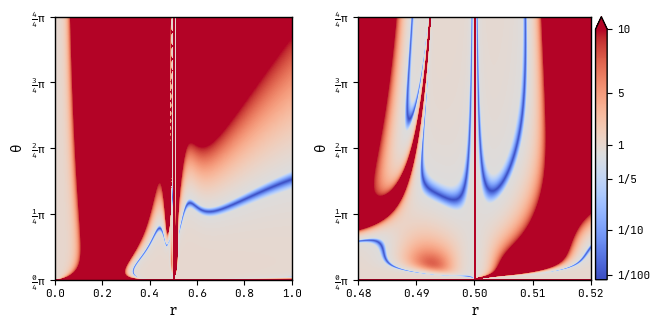

In [20]:
two_norm = mpl.colors.TwoSlopeNorm(0.25, vmax=10)
cmap = mpl.colormaps['coolwarm'].copy()
cmap.set_over(cmap(1.0))
cmap.set_bad(cmap(1.0))

fig, (ax1, ax2) = plt.subplots(1,2,
  figsize=FULL_FIG(0.5),
    width_ratios=[1, 1.05]
)

img = ax1.imshow(
  np.transpose(array),
  extent=extent,
  cmap=cmap,
  norm=two_norm,
  aspect='auto',
  origin='lower'
)

img = ax2.imshow(
  np.transpose(array2),
  extent=extent2,
  cmap=cmap,
  norm=two_norm,
  aspect='auto',
  origin='lower'
)

for ax in (ax1, ax2):
  ax.set_yticks(
    [np.pi*x/4 for x in range(0, 5)],
    labels=[f'$\\frac{{{x}}}{{4}}\pi$' for x in range(0, 5)]
  )
  ax.set_xlabel(f'${sympy.latex(fields[0])}$')
  ax.set_ylabel(f'${sympy.latex(fields[1])}$')

#Make colorbar
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(
  img,
  extend='max',
  location='right',
  ticks=[1/100, 1/10, 1/5, 1, 5, 10],
  cax=cax
)
cax.set_yticklabels(['1/100','1/10','1/5', '1', '5', '10'])

fig.savefig('../out/egno.svg', transparent=True, bbox_inches="tight", pad_inches=0.05)
fig.show()

In [136]:
r_start, r_stop = 0.4, 0.6
pot_calc = anguelova.calc_V_array(
  args,
  [r_start, θ_start],
  [r_stop, θ_stop],
  [N_r, N_θ]
)

In [137]:
print(pot_calc)

[[-3.00000000e-08 -3.00296088e-08 -3.01184353e-08 ... -2.94614268e-05
  -2.95204964e-05 -2.95796252e-05]
 [-3.02836451e-08 -3.03135578e-08 -3.04032958e-08 ... -2.97637618e-05
  -2.98234376e-05 -2.98831732e-05]
 [-3.05706112e-08 -3.06008315e-08 -3.06914925e-08 ... -3.00698378e-05
  -3.01301273e-05 -3.01904773e-05]
 ...
 [-8.54274571e-07 -8.55119733e-07 -8.57655221e-07 ... -8.40953286e-04
  -8.42639385e-04 -8.44327174e-04]
 [-8.39175206e-07 -8.40004766e-07 -8.42493444e-07 ... -8.25428779e-04
  -8.27083750e-04 -8.28740381e-04]
 [-8.24420233e-07 -8.25234555e-07 -8.27677519e-07 ... -8.10267303e-04
  -8.11891875e-04 -8.13518075e-04]]


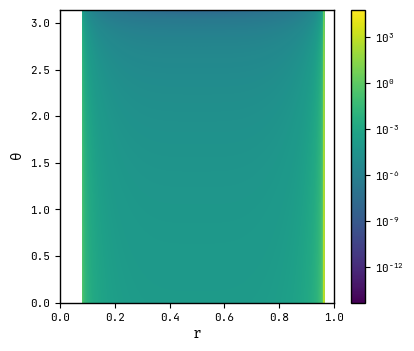

In [138]:
plt.figure(figsize=MAIN_FIG(0.85))
plt.imshow(np.transpose(pot_calc),
  extent=extent,
  aspect='auto',
  norm=mpl.colors.LogNorm()
)
plt.xlabel(f'${sympy.latex(fields[0])}$')
plt.ylabel(f'${sympy.latex(fields[1])}$')
plt.colorbar(location='right', aspect=20)
plt.savefig('../out/egnopot.svg', transparent=True, bbox_inches="tight", pad_inches=0.05)
plt.show()

/tmp/ipykernel_6631/1668009109.py:7: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.transpose(pot_calc)),
/tmp/ipykernel_6631/1668009109.py:7: RuntimeWarning: invalid value encountered in log10
  np.log10(np.transpose(pot_calc)),
/tmp/ipykernel_6631/1668009109.py:40: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist=12
/tmp/ipykernel_6631/1668009109.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig('../out/egnopot.svg', transparent=True)


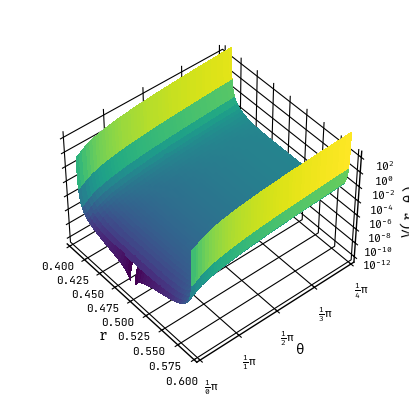

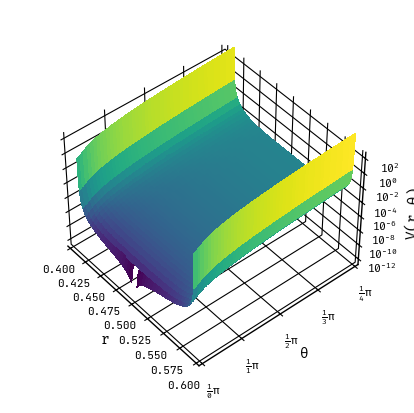

In [147]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=MAIN_FIG(1))
rs = np.linspace(r_start, r_stop, N_r)
θs = np.linspace(θ_start, θ_stop, N_θ)

ax.plot_surface(
  *np.meshgrid(rs, θs),
  np.log10(np.transpose(pot_calc)),
  linewidth=0,
  antialiased=False,
  cmap='viridis'
)

ax.set_xlabel(f'${sympy.latex(fields[0])}$')
ax.set_ylabel(f'${sympy.latex(fields[1])}$')
ax.set_zlabel(f'$V({sympy.latex(fields[0])},{sympy.latex(fields[1])})$')

ax.set_zlim(-12.5, 2.5)
ax.set_xlim(r_start, r_stop)
ax.set_ylim(θ_start, θ_stop)

ax.set_yticks(
  [np.pi*x/4 for x in range(0, 5)],
  labels=[f'$\\frac{{1}}{{{x}}}\pi$' for x in range(0, 5)]
)
ax.set_zticks(
  [x for x in range(-12, 4, 2)],
  [f'$10^{{{x}}}$' for x in range(-12, 4, 2)]
)

wit, zwart = (1.0, 1.0, 1.0, 0.0), (0.0, 0.0, 0.0, 1.0)
ax.xaxis.set_pane_color(wit)
ax.yaxis.set_pane_color(wit)
ax.zaxis.set_pane_color(wit)

ax.xaxis._axinfo["grid"]['color'] = zwart
ax.yaxis._axinfo["grid"]['color'] = zwart
ax.zaxis._axinfo["grid"]['color'] = zwart

ax.view_init(45, 320)
ax.dist=12

fig.savefig('../out/egnopot.svg', transparent=True)
fig